TODO:
# Business Hours Column

# GeoMap
# Latitude, Longitude

# Make If-Else statement before running model
    - if EXCLUSIVE_USE_REQUESTED: only run FTL model
    - if HAZARDOUS: only run FTL model

In [1]:
import sys

import pandas as pd
import numpy as np

sys.path.insert(1, "../src/features")

import data_cleaning

import seaborn as sns
sns.set_theme()
import matplotlib.pyplot as plt

%matplotlib inline
%config InlineBackend.figure_format='retina'

In [2]:
OFFER_DATA_DIR = "../data/offer_acceptance_offers.csv"
ORDER_DATA_DIR = "../data/offer_acceptance_orders.csv"

offers = pd.read_csv(OFFER_DATA_DIR, low_memory=False)[["CARRIER_ID", "REFERENCE_NUMBER", "CREATED_ON_HQ", "RATE_USD", "OFFER_TYPE", "LOAD_DELIVERED_FROM_OFFER"]]
orders = pd.read_csv(ORDER_DATA_DIR, low_memory=False)[["REFERENCE_NUMBER", "ORDER_DATETIME_PST", "PICKUP_DEADLINE_PST", "ORIGIN_3DIGIT_ZIP", "DESTINATION_3DIGIT_ZIP", "APPROXIMATE_DRIVING_ROUTE_MILEAGE", "PALLETIZED_LINEAR_FEET"]]

In [3]:
offers = data_cleaning.change_to_date(offers, ["CREATED_ON_HQ"])
orders = data_cleaning.change_to_date(orders, ["ORDER_DATETIME_PST", "PICKUP_DEADLINE_PST"])

orders = data_cleaning.parse_zipcode(orders)

orders = data_cleaning.parse_datetime(orders)

offers = data_cleaning.flatten_ref_num(offers)
orders = data_cleaning.flatten_ref_num(orders)

In [4]:
merged = data_cleaning.join_offers_orders(offers, orders, how="inner")

merged = data_cleaning.get_remaining_time(merged)

merged = data_cleaning.during_business_hours(merged)

merged = data_cleaning.impute_mileage(merged)

merged = data_cleaning.get_business_hours(merged)

In [5]:
merged.head(1)

,CARRIER_ID,REFERENCE_NUMBER,CREATED_ON_HQ,RATE_USD,OFFER_TYPE,LOAD_DELIVERED_FROM_OFFER,ORDER_DATETIME_PST,PICKUP_DEADLINE_PST,ORIGIN_3DIGIT_ZIP,DESTINATION_3DIGIT_ZIP,...,DESTINATION_CITY,ORDER_DAY,ORDER_MONTH,ORDER_HOUR,PICKUP_DAY,PICKUP_MONTH,PICKUP_HOUR,REMAINIG_TIME,BUSINESS_HOURS,BUSINESS_HOURS_ORDER_PICKUP
0,0629d63476c157a6cfe234f7a34422eb0ad94998c2d082...,ce3548db155049cc1ccce2da041cec607942e4f779fc2d...,2021-11-03 08:54:13,9546.0,pool,False,2021-11-02 12:56:49,2021-11-03 16:00:00,945,601,...,Chicago IL,1,11,12,2,11,16,25547.0,True,13.053056


In [6]:
merged.dtypes

CARRIER_ID                                   object
REFERENCE_NUMBER                             object
CREATED_ON_HQ                        datetime64[ns]
RATE_USD                                    float64
OFFER_TYPE                                   object
LOAD_DELIVERED_FROM_OFFER                      bool
ORDER_DATETIME_PST                   datetime64[ns]
PICKUP_DEADLINE_PST                  datetime64[ns]
ORIGIN_3DIGIT_ZIP                            object
DESTINATION_3DIGIT_ZIP                       object
APPROXIMATE_DRIVING_ROUTE_MILEAGE           float64
PALLETIZED_LINEAR_FEET                      float64
ORIGIN_CITY                                  object
DESTINATION_CITY                             object
ORDER_DAY                                     int64
ORDER_MONTH                                   int64
ORDER_HOUR                                    int64
PICKUP_DAY                                    int64
PICKUP_MONTH                                  int64
PICKUP_HOUR 

In [7]:
# filter FTL offers
unpooled_offers = offers[offers["OFFER_TYPE"] == "quote"]

# filter PTL offers
pooled_offers = offers[offers["OFFER_TYPE"] == "pool"]

In [8]:
print("Total of unpooled offers are: " + str(unpooled_offers.shape[0]))
print("Total of pooled offers are: " + str(pooled_offers.shape[0]))

Total of unpooled offers are: 594417
Total of pooled offers are: 243655


In [9]:
num_cols = merged[["RATE_USD", "APPROXIMATE_DRIVING_ROUTE_MILEAGE", 
                   "PALLETIZED_LINEAR_FEET", "REMAINIG_TIME", 
                   "BUSINESS_HOURS_ORDER_PICKUP"]]

<AxesSubplot:>

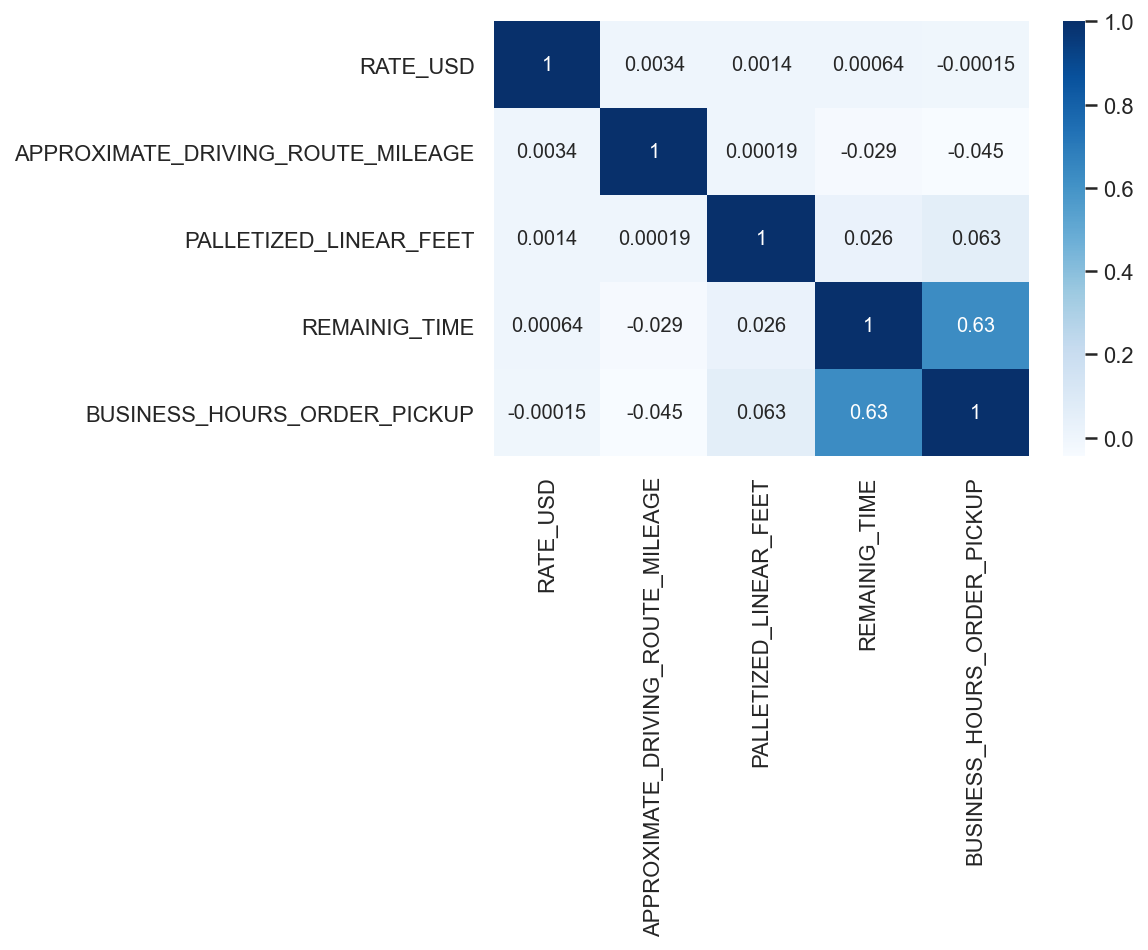

In [10]:
sns.heatmap(num_cols.corr(), cbar=True, annot=True, cmap='Blues')

Analysis:

First of all, we focused on all the numerical elements in the dataset because they are the most straightforward and contain useful information regarding the shipment. According to the heatmap, we noticed that APPROXIMATE_DRIVING_ROUTE_MILEAGE, and REMAINIG_TIME have positive correlations with RATE_USD because they have positive coefficients. BUSINESS_HOURS_ORDER_PICKUP has a negative correlations with RATE_USD because it has a negative coefficient.

In [11]:
Q1 = np.percentile(merged["RATE_USD"], 25,
                   interpolation = 'midpoint')
 
Q3 = np.percentile(merged["RATE_USD"], 75,
                   interpolation = 'midpoint')

IQR = Q3 - Q1

merged = merged[(merged["RATE_USD"] < (Q3 + 1.5 * IQR)) & 
                (merged["RATE_USD"] > Q1 - 1.5 * IQR)]

Some data have really large RATE_USD, so I used the percentile to remove the outliers for a better visualization.

<AxesSubplot:xlabel='APPROXIMATE_DRIVING_ROUTE_MILEAGE', ylabel='RATE_USD'>

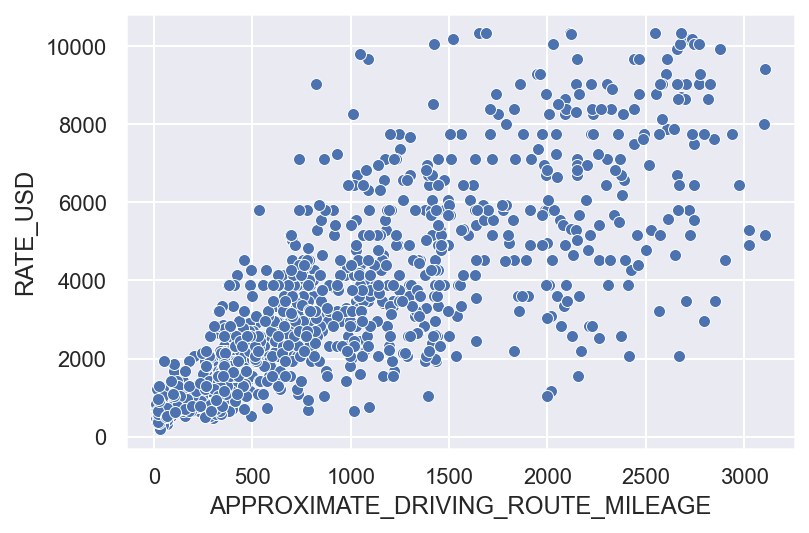

In [12]:
sns.scatterplot(x='APPROXIMATE_DRIVING_ROUTE_MILEAGE', 
            y='RATE_USD', data=merged.sample(n=1000))

<AxesSubplot:xlabel='PALLETIZED_LINEAR_FEET', ylabel='RATE_USD'>

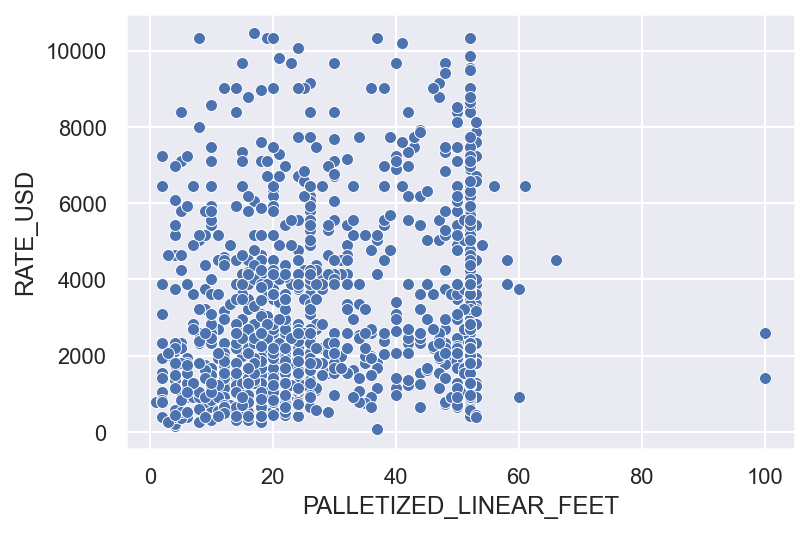

In [13]:
sns.scatterplot(x='PALLETIZED_LINEAR_FEET', 
            y='RATE_USD', data=merged.sample(n=1000))

<AxesSubplot:xlabel='REMAINIG_TIME', ylabel='RATE_USD'>

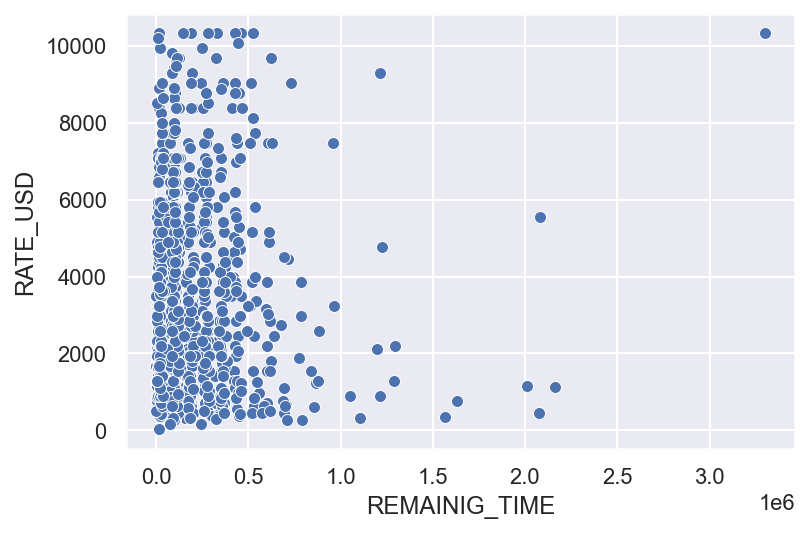

In [14]:
sns.scatterplot(x='REMAINIG_TIME', 
                y='RATE_USD', data=merged.sample(n=1000))

<AxesSubplot:xlabel='BUSINESS_HOURS_ORDER_PICKUP', ylabel='RATE_USD'>

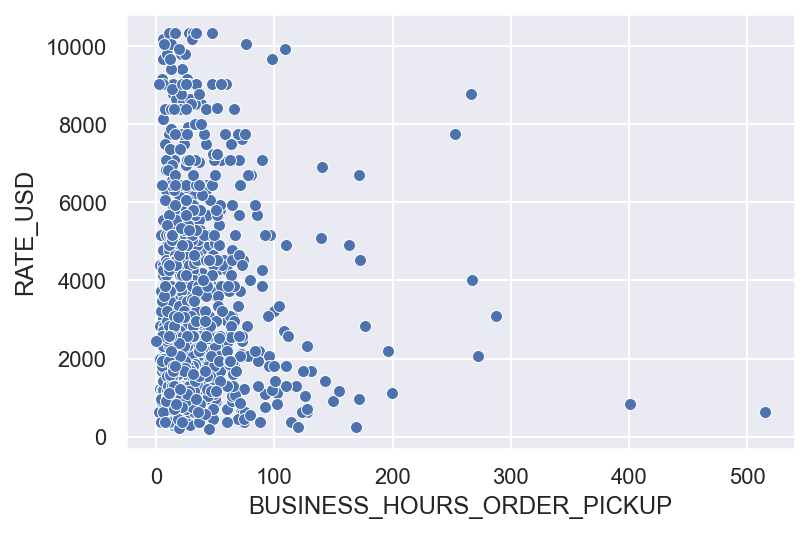

In [15]:
sns.scatterplot(x='BUSINESS_HOURS_ORDER_PICKUP', 
                y='RATE_USD', data=merged.sample(n=1000))

In [16]:
merged["ORIGIN_CITY"].value_counts()[:10]

Rancho Cucamonga CA    84929
Atlanta GA             57155
Dallas TX              55058
Whittier CA            30671
San Bernardino CA      29907
Los Angeles CA         29370
Oakland CA             29139
Fort Worth TX          25147
Stockton CA            20057
Riverside CA           18899
Name: ORIGIN_CITY, dtype: int64

In [17]:
merged["DESTINATION_CITY"].value_counts()[:10]

Dallas TX              37448
San Bernardino CA      28923
Atlanta GA             24947
Chicago IL             24297
Stockton CA            20116
Rancho Cucamonga CA    18165
Houston TX             15315
Oakland CA             15023
San Antonio TX         14266
Portland OR            14020
Name: DESTINATION_CITY, dtype: int64

In [18]:
# import geopandas
# import pandas as pd
# import pandas_bokeh
# import matplotlib.pyplot as plt
# pandas_bokeh.output_notebook()

# canada = geopandas.read_file("./gfsa000b11a_e.shp")
# ontario = canada[canada['PRUID'] == '35']

# # Sample data to plot
# df=pd.DataFrame({'PCODE': ['P0V','P0L','P0T','P0Y', 'P0G', 'P2N'], 'A':[6,3,5,2,2,4] })

# # Join ontario dataset with sample data
# new_df=ontario.join(df.set_index('PCODE'), on='CFSAUID')


# new_df.plot_bokeh(simplify_shapes=20000,
#                   category="A", 
#                   colormap="Spectral", 
#                   hovertool_columns=["CFSAUID","A"])